<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Orders.csv" data-toc-modified-id="Orders.csv-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Orders.csv</a></span></li><li><span><a href="#order_products__prior" data-toc-modified-id="order_products__prior-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>order_products__prior</a></span></li></ul></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib

Ethen 2018-09-16 08:30:25 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.1
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2


# Exploratory Data Analysis

Some background information based on the following link. [Blog: 3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

The Instacart ordering dataset potential applications might include

- predicting products that a user will buy again.
- try for the first time.
- add to cart during the next session.
- etc.

According to the blog post, Instacart currently uses XGBoost, word2vec and Annoy in production to rank/sort items on the buy it again and frequently bought together with xyz item (replace xyz with whatever item you have in mind) strip.

For the first use-case. We can train the order-product level binary classification. Then we can recommend the product that are higher than a certain threshold. Features could include:

- **Product Features:**
    - Product's category. Instacart categorizes them into department (e.g. bakery, frozen) and aisle (e.g. granola bars, salads).
    - Historical performance of the product. e.g. number of times it was ordered; number of times it was re-ordered (re-ordered indicates the customer has a previous order that contains the product).
    - Whether the product is the top-n most popular products.
- **User Features:**
    - Number of orders the user has placed.
    - Number of products / distinct products the user has ordered. With the distinct and non-distinct product count, we can also calculate the average basket size for a user.
    - Time between orders (e.g. average days between order).
    - Tendency of buying new items. e.g. average proportion of new items in each order.
- **Order Features:**
    - Time of the order such as day of week, hour of day.
    - Order number (kind of like order frequency).
    - Days since prior order (kind of like order recency).
- **User-Product Features:**
    - Number of orders including that product in the past. Or expressed in ratio. Out of the total number of orders the user has placed, the ratio of orders that included that product.
    - Instacart even has position in the cart feature, so we can compute features such as average position of that product for each user.
    - Days since the user last purchased the item.
    - Streak (number of orders in a row the user has purchased the item).

## Orders.csv

In [2]:
data_dir = os.path.join('..', 'all')

# the orders.csv is the main table that gives us a list
# all the orders for the user. e.g. user 1 has 11 orders,
# of which 10 are prior orders and 1 is in the train set.
# (more explanation down below)
# The orders.csv table doesn't tell us which products
# were ordered, this information is in a separate table,
# order_products.csv
orders_path = os.path.join(data_dir, 'orders.csv')
df_orders = pd.read_csv(orders_path)

print('dimension: ', df_orders.shape)
df_orders.head(12)

dimension:  (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


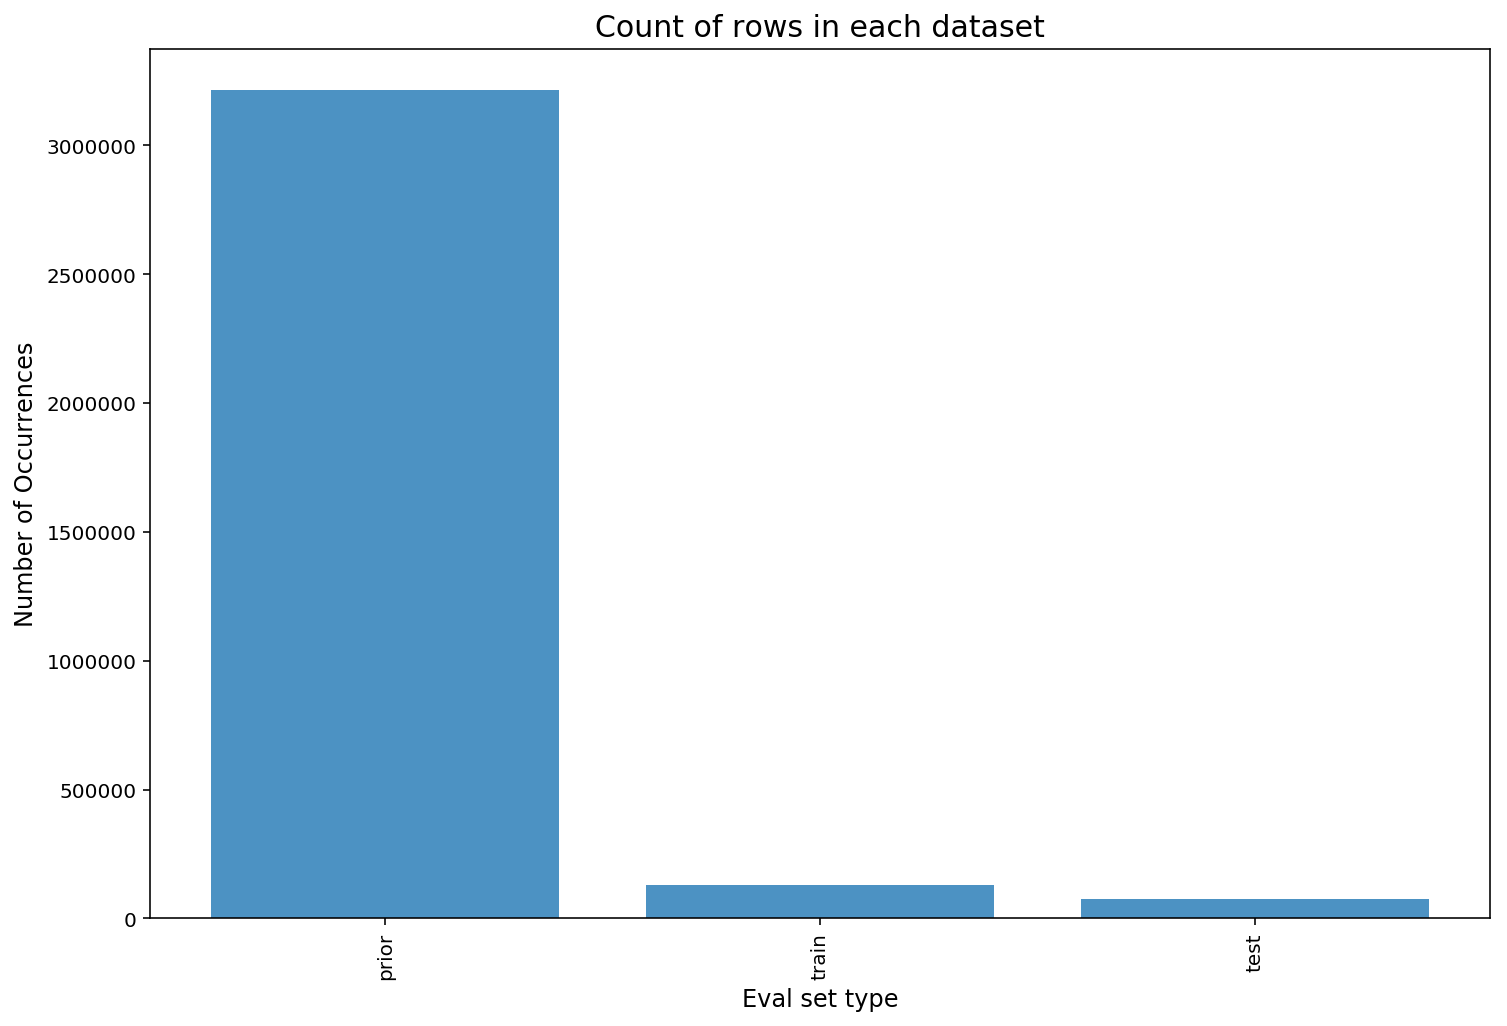

In [3]:
# the eval_set column tells us which of the three dataset (prior, train or test)
# the given row goes to
eval_set_counts = df_orders.eval_set.value_counts()

plt.figure(figsize=(12, 8))
plt.bar(eval_set_counts.index, eval_set_counts.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [4]:
# there are 206,209 customers in total. Out of which, the
# last purchase of 131,209 customers are given as train set
# and we need to predict for the rest 75,000 customers
user_count = df_orders.groupby("eval_set")["user_id"].nunique()
user_count

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

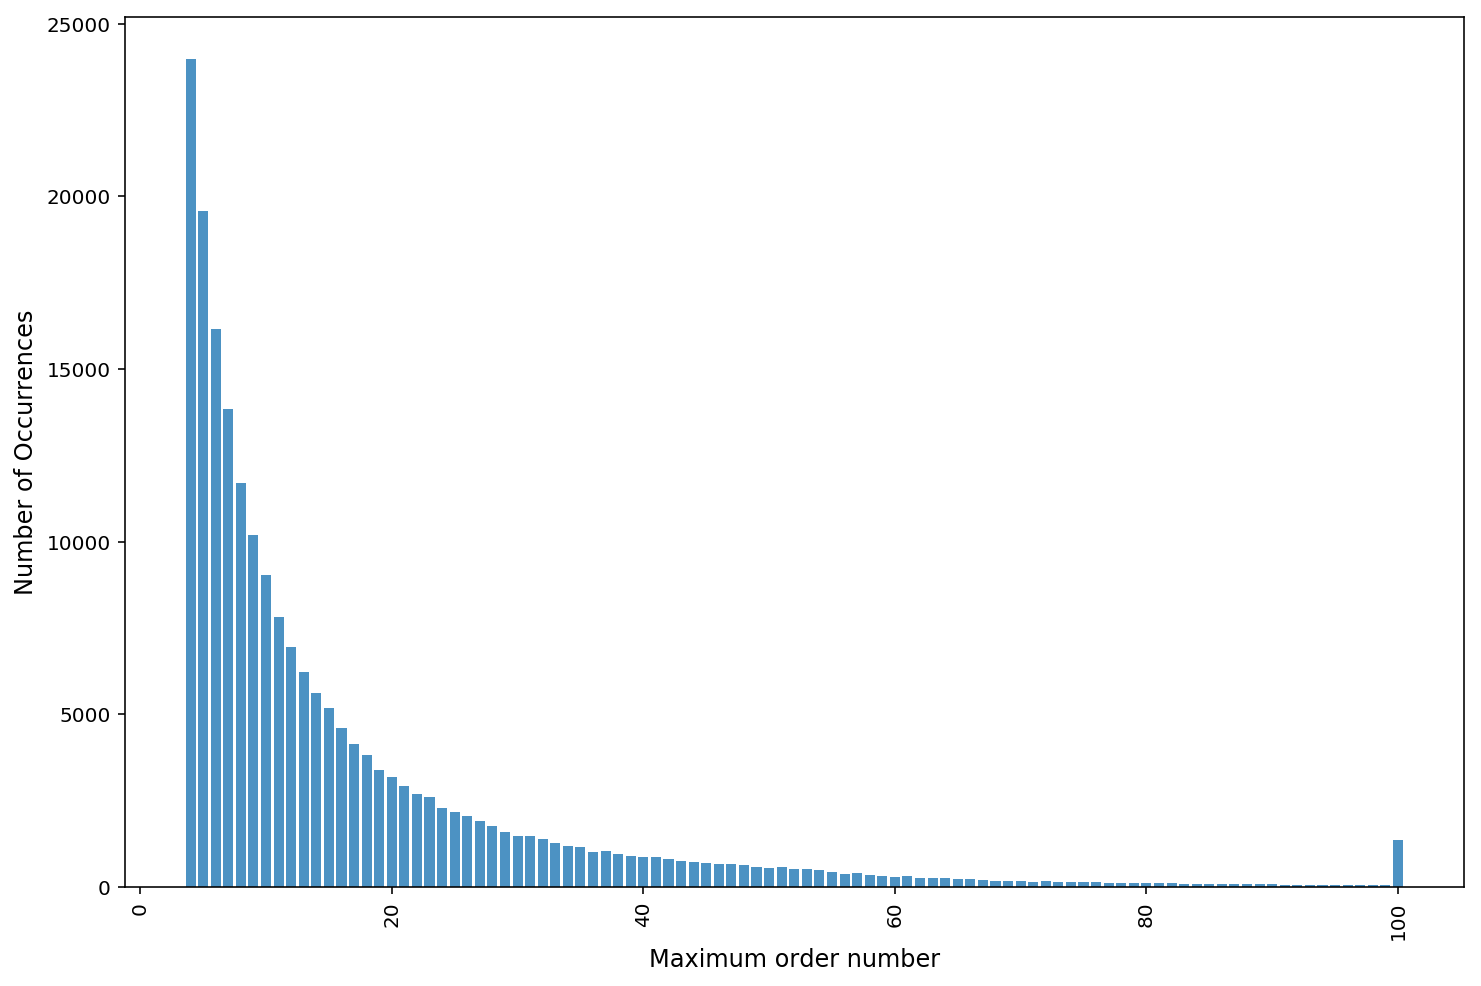

In [5]:
# the data dictionary claims that 4 to 100 orders of a customer are given,
# we can validate that here, though we can't be sure if the number of orders
# is censored or not (i.e. in real word, it probably won't be bounded like this,
# they might have removed the "outliers")
order_count = df_orders.groupby("user_id")["order_number"].agg(np.max).reset_index()
order_count = order_count.order_number.value_counts()

plt.figure(figsize=(12, 8))
plt.bar(order_count.index, order_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

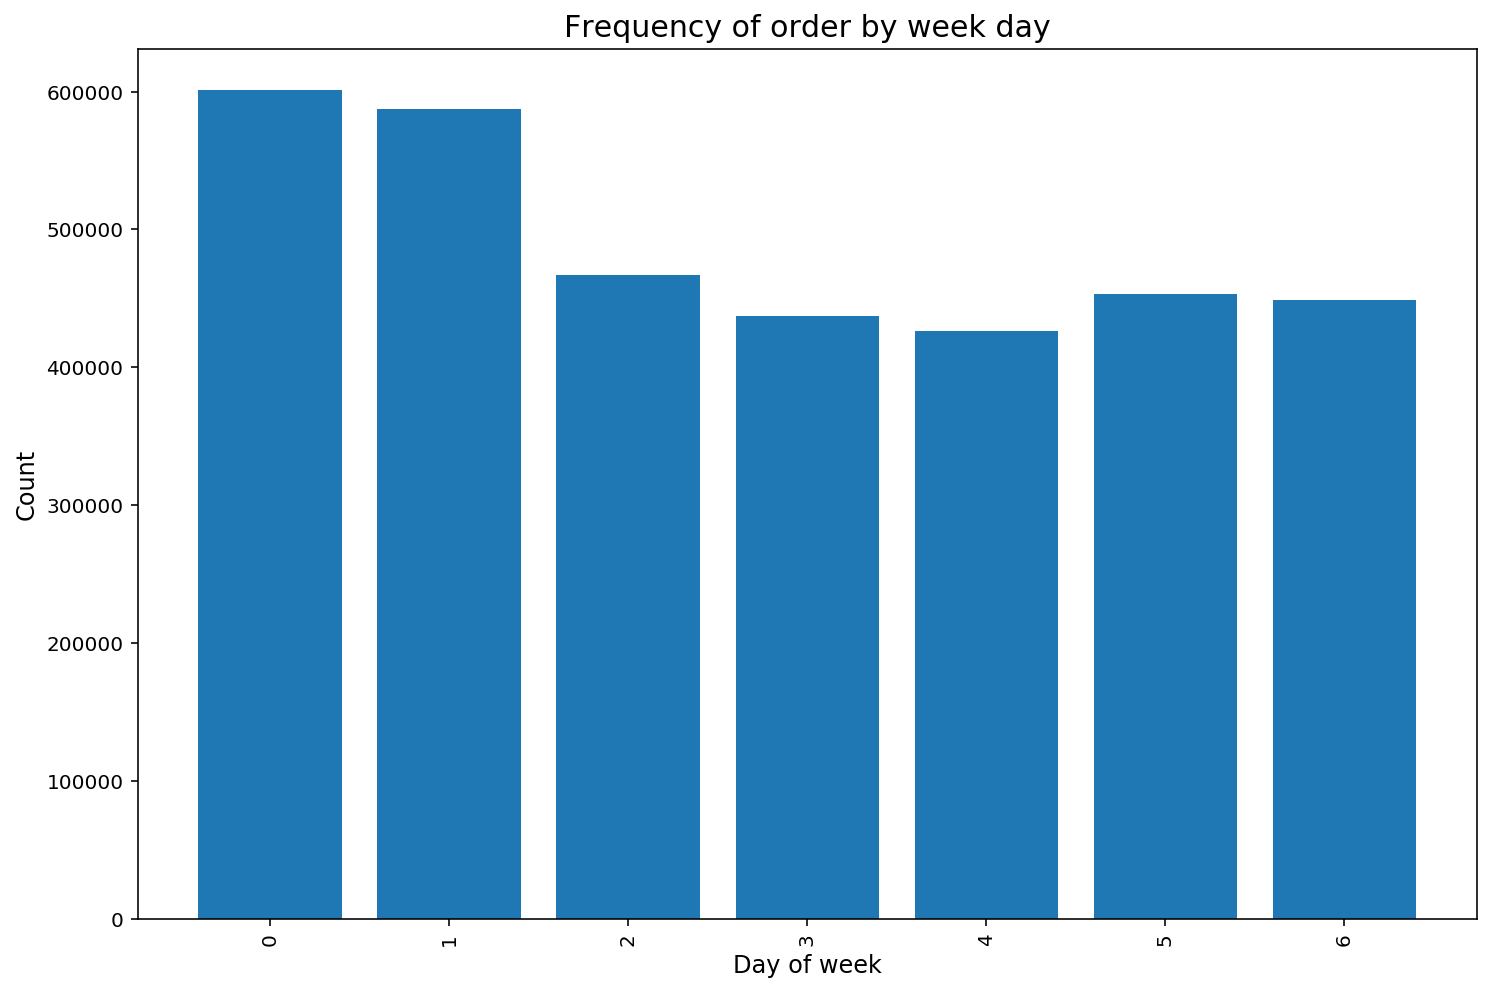

In [6]:
# we can look at when do people order, there are more
# orders on day 0 and 1, there is no info regarding which
# day this value represents, why we can probably safely assume
# that these are the weekends
order_dow_count = df_orders['order_dow'].value_counts()

plt.figure(figsize=(12,8))
plt.bar(order_dow_count.index, order_dow_count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

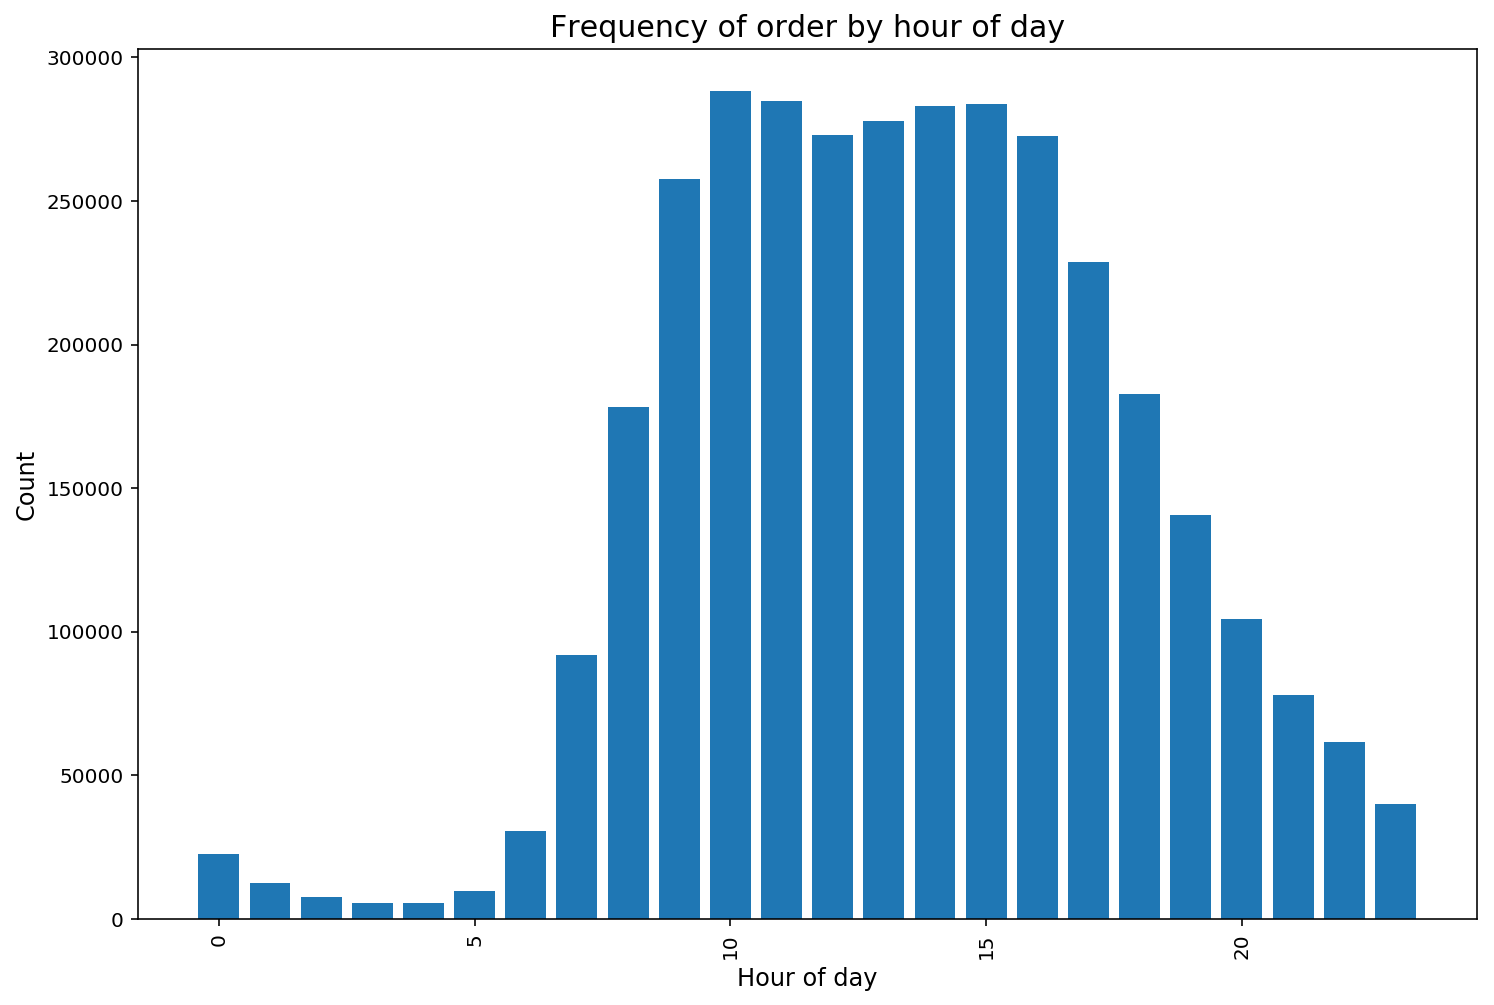

In [7]:
# based on the distribution hour of day has a clear effect on the
# ordering volumne
order_hod_count = df_orders['order_hour_of_day'].value_counts()

plt.figure(figsize=(12,8))
plt.bar(order_hod_count.index, order_hod_count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

In [8]:
# interactions between day of week and hour of day
order_count = (df_orders.
               groupby(["order_dow", "order_hour_of_day"]).
               size().
               reset_index(name='count').
               pivot(index='order_dow', columns='order_hour_of_day', values='count'))
order_count.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,...,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,...,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,...,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,...,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,...,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645


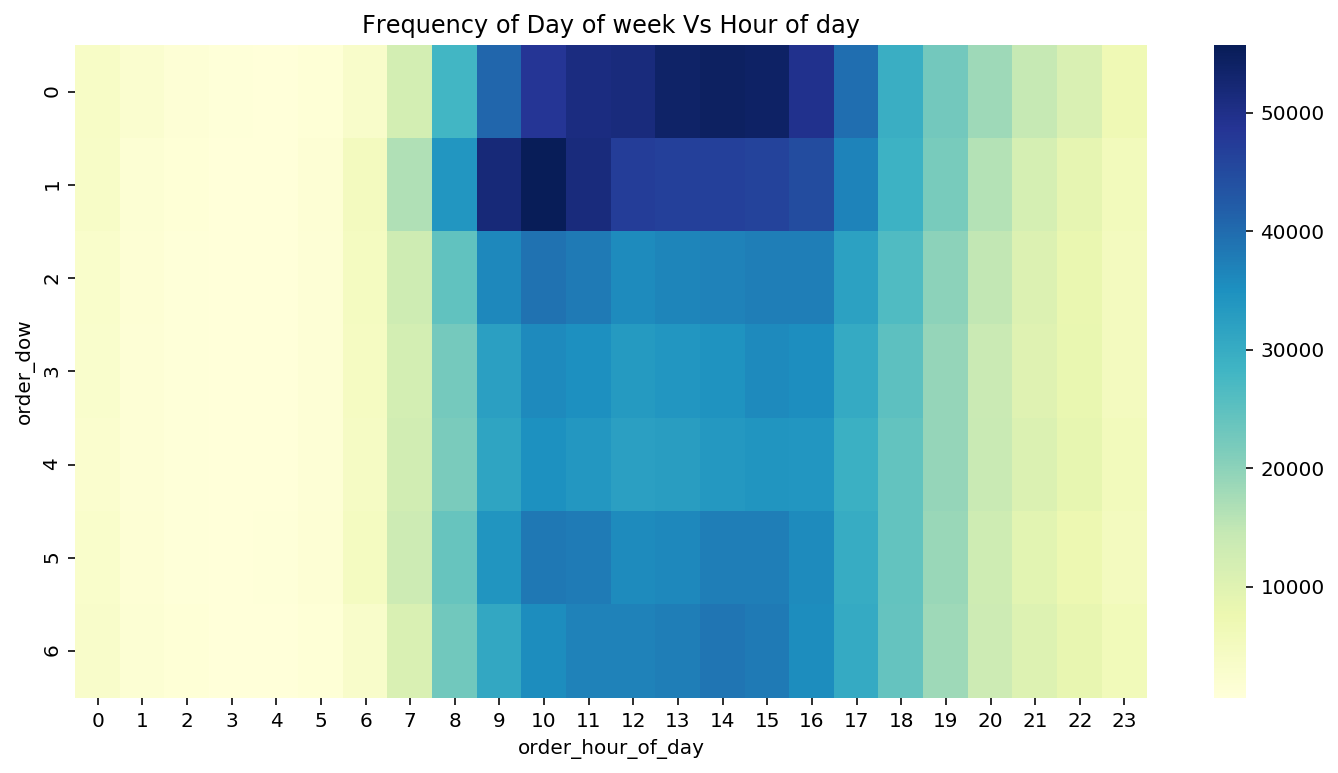

In [9]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(order_count, cmap='YlGnBu')
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

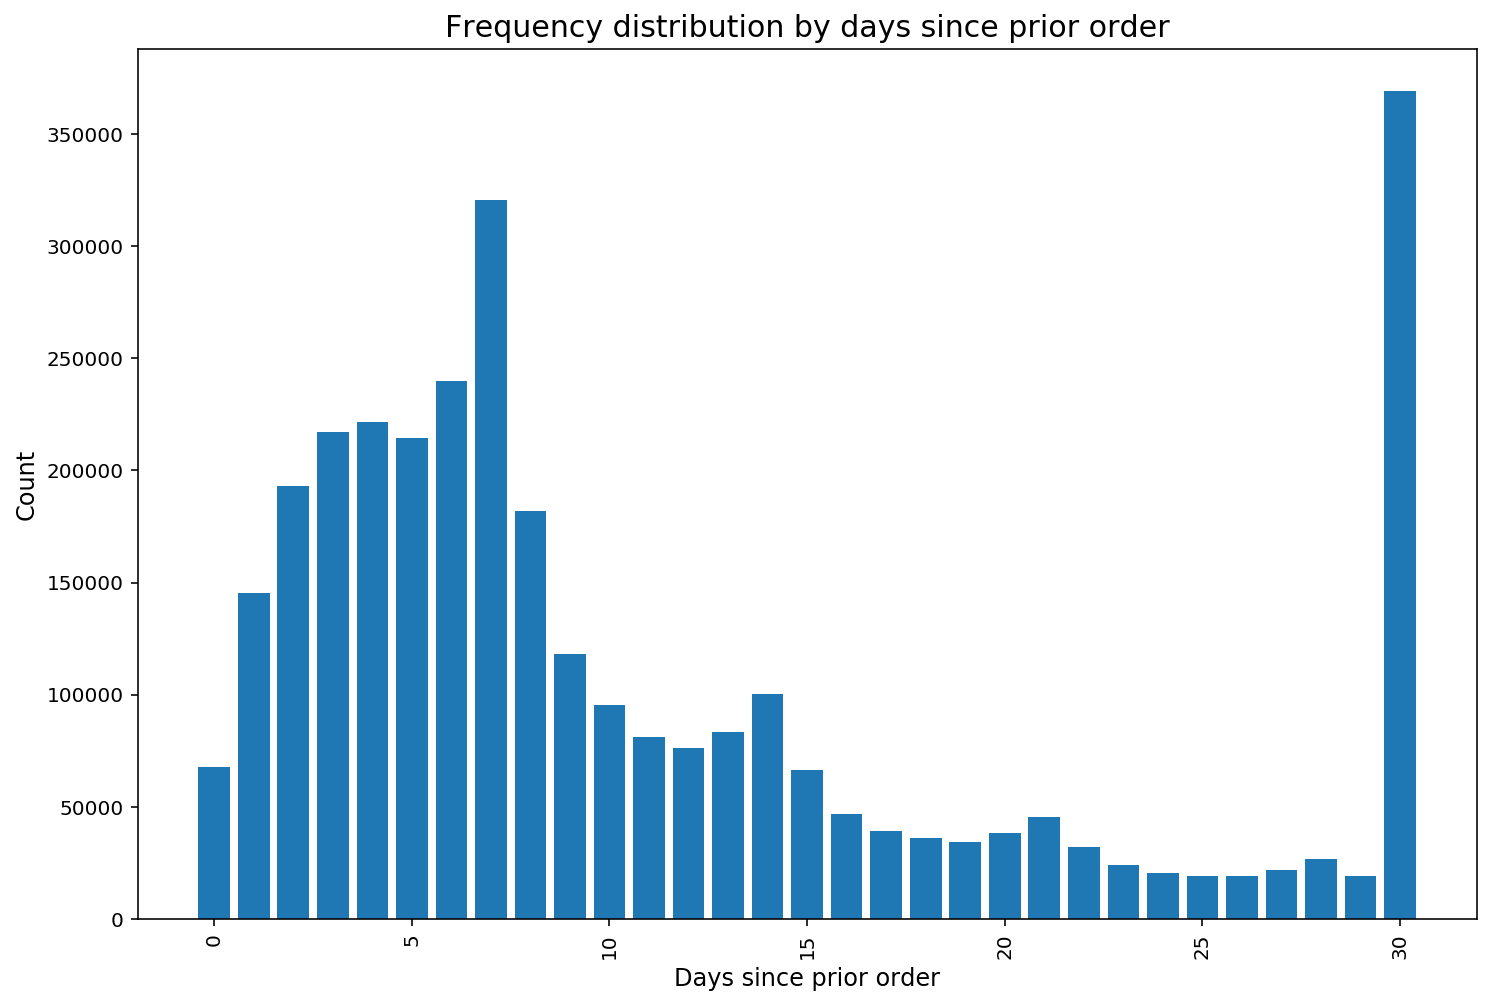

In [10]:
# looking at days since prior order, seems like customer order once every week or
# once in a month (chart peeked at 30)
days_prior_order_count = df_orders['days_since_prior_order'].value_counts(dropna=False)

plt.figure(figsize=(12,8))
plt.bar(days_prior_order_count.index, days_prior_order_count.values)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

## order_products__prior

In [11]:
# order_products contains what products were included within each order_id
prior_orders_path = os.path.join(data_dir, 'order_products__prior.csv')
df_prior_orders = pd.read_csv(prior_orders_path)
print('dimension: ', df_prior_orders.shape)
df_prior_orders.head()

dimension:  (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [12]:
# checking the re-ordered distribution
df_prior_orders['reordered'].sum() / df_prior_orders['reordered'].shape[0]

0.5896974667922161

In [13]:
train_orders_path = os.path.join(data_dir, 'order_products__train.csv')
df_train_orders = pd.read_csv(train_orders_path)
print('dimension: ', df_train_orders.shape)
df_train_orders.head()

dimension:  (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [14]:
df_orders[df_orders['order_id'] == 1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
